# Large Language Models for Home Energy Management System parametrization

This notebook is a overview of how LLMs can be used to simplify Home Energy Management Systems parametrization.


First, we will download the github repository containing the necessary codes.

In [ ]:
import os
from getpass import getpass
import urllib

cmd_string = 'git clone https://github.com/EsaLaboratory/LLM.git'

os.system(cmd_string)

0

Then we need to install all the libraries.

In [ ]:
!pip3 -q install ipykernel jupyter
!pip3 -q install torch torchvision torchaudio transformers
!pip3 -q install packaging ninja
!pip -q install accelerate
!pip3 -q install protobuf
!pip3 -q install sentencepiece
!pip3 -q install bitsandbytes
!pip3 -q install scipy
!pip3 -q install pandas
!MAX_JOBS=4 pip -q install flash-attn --no-build-isolation
!pip -q install -U sentence-transformers
!pip -q install PICOS

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel

We import the libraries and the LLM prompts (ReAct agent and user).

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, StoppingCriteria
from transformers import BitsAndBytesConfig, TextStreamer
from random import randrange
from typing import Callable, Any, Dict, Tuple, Union
from string import Template
import json
import time
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from LLM.scripts.home_management import Market, Model, tests
import re
import sys

print("import succesful")

with open("./LLM/data/system_prompt.txt", 'r') as prompt:
    PROMPT = ''.join(line for line in prompt.readlines())
    prompt.close()

with open("./LLM/data/system2_prompt.txt", 'r') as prompt:
    PROMPT_NOREACT = ''.join(line for line in prompt.readlines())
    prompt.close()

with open("./LLM/data/format_prompt.txt", 'r') as format_prompt:
    FORMAT_PROMPT = ''.join(line for line in format_prompt.readlines())
    format_prompt.close()

ERROR_PROMPT = Template("""You made a mistake in your JSON blob.
Here is the Python error message: $ERROR

Remember, `action_input` must be a valid Python object (str, int, list, float).
Try again with the right format and the right keys."""
                        ).safe_substitute(FORMATPROMPT=FORMAT_PROMPT)

ERROR_PROMPT = Template(ERROR_PROMPT)

with open(r'./LLM/data/example_user_1.json', 'r',
          encoding="utf8") as example_user_1:
    EXAMPLE_USER_1 = json.load(example_user_1)
    with open(r'./LLM/data/' + EXAMPLE_USER_1['answer']) as answer_user_1:
        EXAMPLE_USER_1['answer'] = ''.join(
            line for line in answer_user_1.readlines())
        answer_user_1.close()
    example_user_1.close()

with open(r'./LLM/data/example_user_1.json', 'r',
          encoding="utf8") as example_user_1:
    EXAMPLE_USER_NOREACT = json.load(example_user_1)
    with open(r'./LLM/data/' + 'example_user_noreact.txt') as answer_user_1:
        EXAMPLE_USER_NOREACT['answer'] = ''.join(
            line for line in answer_user_1.readlines())
        answer_user_1.close()
    example_user_1.close()

with open("./LLM/data/init_user_prompt_easy.txt", 'r') as user_prompt:
    INIT_USER_PROMPT_EASY = ''.join(line for line in user_prompt.readlines())
    user_prompt.close()

with open("./LLM/data/init_user_prompt_medium.txt", 'r') as user_prompt:
    INIT_USER_PROMPT_MEDIUM = ''.join(line for line in user_prompt.readlines())
    user_prompt.close()

with open("./LLM/data/init_user_prompt_hard.txt", 'r') as user_prompt:
    INIT_USER_PROMPT_HARD = ''.join(line for line in user_prompt.readlines())
    user_prompt.close()

with open(r'./LLM/data/tasks.json') as tasks_list:
    TASKS = json.load(tasks_list)
    tasks_list.close()

print('prompts loaded')

import succesful
prompts loaded


We need to use a chat template for the prompts to make the LLM understand its tasks.

In [ ]:
messages_user = [
    {"role": "system", "content": PROMPT},
    {"role": "agent", "content": EXAMPLE_USER_1["task"]},
    {"role": "assistant", "content": EXAMPLE_USER_1["answer"]},
    {"role": "agent", "content": "$TASK"},
]

messages_user_noreact = [
    {"role": "system", "content": PROMPT_NOREACT},
    {"role": "agent", "content": "$TASK"},
]


USER_PROMPT_EASY = Template(f"""<|im_start|>system{INIT_USER_PROMPT_EASY}
<|im_end|>
<|im_start|>agent
$QUERY
<|im_end|>
<|im_start|>user""")

USER_PROMPT_MEDIUM = Template(f"""<|im_start|>system{INIT_USER_PROMPT_MEDIUM}
<|im_end|>
<|im_start|>agent
$QUERY
<|im_end|>
<|im_start|>user""")

USER_PROMPT_HARD = Template(f"""<|im_start|>system{INIT_USER_PROMPT_HARD}
<|im_end|>
<|im_start|>agent
$QUERY
<|im_end|>
<|im_start|>user""")

We define a class call Tool, which will be used by our ReAct LLM agent to interact with the Home Energy Management System and the user. The Tools are stored in an object of the class Toolkit.

In [ ]:
class Tool():
    """A tool that is called by a React agent.

    Attributes:
      function: function to be called.
      name: name of the function.
      documentation: documentation of the function.
      description: function description.
      input: input description of the function.
      output: output description of the function.
    """

    def __init__(self, function: Callable[[Any], Any]):
        """Instantiate a Tool object for a React agent.

        Attributes:
            function: function to be called.
            name: name of the function.
            documentation: documentation of the function.
            description: function description.
            input: input description of the function.
            output: output description of the function.
            nb_calls: number of function calls."""
        self.function = function
        self.name = function.__name__
        self.documentation = function.__doc__
        index_args = self.documentation.index('Args:')
        index_returns = self.documentation.index('Returns:')
        self.description = self.documentation[:index_args].strip()
        self.input = self.documentation[index_args+7:index_returns].strip()
        self.output = self.documentation[index_returns+10:].strip()
        self.nb_calls = 0

    def __repr__(self):
        """Print function description."""
        return str({
            'action': self.name,
            'action_description': self.description,
            'action_input': self.input,
            'action_output': self.output,
        })

    def __call__(self, *args, **kwargs):
        """Call the function of the tool."""
        return self.function(*args, **kwargs)


class Toolkit():
    """List of tools for a React agent.

    Attributes:
        tools: A list of tools.
        names: A list of tools' names."""

    def __init__(self, tools: list[Tool]):
        self.tools = tools
        self.names = '\n'.join(tool.name for tool in tools)

    def tools_description(self):
        return '\n'.join(str(tool) for tool in self.tools)

    def __repr__(self):
        return self.names

To force the ReAct LLM to generate the Thought/Action/Observation format, we need to use stopping criterias to the LLM generation. The class defined below, will help us force the LLM to generate what we want.

In [ ]:
class MyStoppingCriteria(StoppingCriteria):
    """Custom implementation of a stopping criteria.

    Attributes:
        target_sequence: A string that mark the end of the model's generation.
        prompt: A string given to a model.
        last: The generated sequence.
        new_token: Newly generated token.
        tokenizer: The tokenizer assoicated to the LLM."""

    def __init__(self,
                 target_sequence: list[str],
                 prompt: str,
                 tokenizer: AutoTokenizer):
        self.target_sequence = target_sequence
        self.prompt = prompt
        self.last = None
        self.new_token = ''
        self.tokenizer = tokenizer

    def __call__(self, input_ids, scores, **kwargs):
        # Get the generated text as a string
        generated_text = self.tokenizer.decode(input_ids[0])
        if self.last:
            self.new_token += generated_text.replace(self.last, '')
        # Check if the target sequence appears in the generated text
        for sequence in self.target_sequence:
            if re.search(sequence.lower(), self.new_token.lower()):
                return True    # Stop generation

        self.last = generated_text
        return False    # Continue generation

    def __len__(self):
        return 1

    def __iter__(self):
        yield self

The class Parser retrieves from the LLM-generated JSON, the tool name and its input(s). If the JSON is correct, then this parser will return the tool outputs. In the other case, it will return an error message.

In [ ]:
class Parser():
    """Parse tool calls inputs and outpus."""

    def __init__(self):
        pass

    def find_json(self, response: str) -> str:
        """Find braces in React agent output.

        Args:
            response: The React agent output.

        Returns:
            The React agent json as a string or an error message."""
        start_index = response.find('{')
        end_index = response.rfind('}')
        if start_index != -1 and end_index != -1:
            return response[start_index:end_index+1]
        else:
            return "Braces not found or improperly placed."

    def call_function(self,
                      name: str,
                      arguments: Union[str, float, int, list],
                      toolkit: Toolkit) -> Union[str, float, int, list]:
        """Call a function with arguments.

        Args:
            name: Name of the function
            arguments: Arguments of the function
            toolkit: List of tools

        Returns:
            The result of the function or an error message"""
        if name in toolkit.names:
            index = toolkit.names.split('\n').index(name)
            function_to_call = toolkit.tools[index]
            function_to_call.nb_calls += 1
            try:
                arg = list(arguments.values())[0]
                return function_to_call(arg)
            except:
                return function_to_call(arguments)
        else:
            return f"Function {name} not found."

    def process(self,
                response: str,
                toolkit: Toolkit,
                done: bool) -> Union[str, float, int, list]:
        """Parse an React agent output and call function.

        Args:
            response: The React agent output.
            toolkit: List of tools of the React agent.

        Returns:
            The result of the function or an error message"""
        if not done:
            result = self.find_json(response)
            if result.startswith("{") and result.endswith("}"):
                try:
                    data = json.loads(result)
                    try:
                        return self.call_function(
                            data['action'], data['action_input'],
                            toolkit)
                    except Exception as e:
                        error = ERROR_PROMPT.safe_substitute(
                            ERROR=type(e).__name__+str(e))
                        return error
                except Exception as e:
                    error = ERROR_PROMPT.safe_substitute(
                        ERROR=type(e).__name__+str(e))
                    return error
            else:
                return ERROR_PROMPT.safe_substitute(ERROR=result)
        else:
            return ''

Class ReAct defines the LLM ReAct agent. This agent needs to be given a prompt and a tasks. After that it will try to find all user parameters that are necessary for the Home Energy Management System parametrization.

Class User defines an LLM-user. For testing purposes, we created this class to test the ReAct agent when he has to deal with several user types.

In [ ]:
class React():
    """React agent that solves tasks for an Energy Management System

    Attributes:
      model: A llm model
      tokenizer: A tokenizer associated to a model
      toolkit: A list of tools for the agent
      parser: A parser that will parse Llm's tool call
      system_prompt: Initial React prompt
      streamer: Streamer object indication streaming option for the llm
      prompt: Current prompt value"""

    def __init__(self,
                 model: AutoModelForCausalLM,
                 tokenizer: AutoTokenizer,
                 toolkit: Toolkit,
                 parser: Parser,
                 prompt: str,
                 react: bool = True
                 ):
        self.model = model
        self.tokenizer = tokenizer
        self.toolkit = toolkit
        self.parser = parser
        self.system_prompt = prompt
        self.prompt = ''
        self.repr_index = 0
        self.outputs = []
        self.react = react

    def init_prompt(self, task: str) -> str:
        """Initialize prompt.

        Args:
            task: the task given to the React agent

        Returns:
            The initialized prompt"""
        tools_description = self.toolkit.tools_description()
        tools_list = str(self.toolkit)
        init_prompt = self.system_prompt.safe_substitute(
            TASK=task,
            TOOLS_DESCRIPTION=tools_description,
            TOOLS_LIST=tools_list,
            FORMAT_PROMPT=FORMAT_PROMPT)
        self.repr_index = len(init_prompt)
        return init_prompt

    def done(self, prompt: str) -> bool:
        """Check if the task is done.

        Args:
            prompt: The LLM generated prompt to a task.

        Returns:
            True or False if the task is done or not."""
        end_texts = ['final', 'answer']
        for txt in end_texts:
            if txt in prompt.lower():
                return True

    def get_result(self, prompt: str, task: str, time: float) -> Dict:
        """Return the llm result to a task."""
        try:
            result_index = prompt.lower().rindex('final answer:')
            return {'task': task,
                    'result': prompt[result_index+13:-10], 'time': time}
        except:
            return {'task': task,
                    'result': 'No final answer', 'time': time}

    def __repr__(self) -> str:
        """Return a reprensation of the React agent."""
        return self.prompt[self.repr_index:]

    def __call__(self, task: str, n_iter: int) -> Dict:
        """Apply React method to solve a task.

        Args:
            task: Task description
            n_iter: Maximum number of iteration for the React agent

        Returns:
            A dict with the agent's results"""
        # add clean prompt option so that it is not too long TODO create func
        start = time.time()
        iter = 0
        done = False
        self.prompt = self.init_prompt(task)

        while not done and iter < n_iter:
            encoded_input = self.tokenizer(self.prompt,
                                           padding=True,
                                           return_tensors='pt')

            input_ids = encoded_input['input_ids'].cuda()
            stopcriteria = [r"Observation:", r"Final Answer:.*\.", r"<|im_end|>"]
            if not self.react:
                stopcriteria.append(r"\}")
            streamer = TextStreamer(self.tokenizer, skip_prompt=True)
            generated_output = self.model.generate(
                input_ids,
                pad_token_id=self.tokenizer.eos_token_id,
                do_sample=True,
                temperature=0.8,
                max_new_tokens=750,
                repetition_penalty=1.1,
                streamer=streamer,
                stopping_criteria=MyStoppingCriteria(stopcriteria, self.prompt, self.tokenizer))

            response = self.tokenizer.decode(
                generated_output[0][input_ids.shape[-1]:],
                skip_special_tokens=False,
                clean_up_tokenization_space=True)

            done = self.done(response)
            iter += 1
            self.outputs.append([response, iter, done])
            output = ' ' + \
                str(self.parser.process(response, self.toolkit, done))
            if "ask_user" not in response:
                sys.stdout.write(output + '\n')
            sys.stdout.write('Thought: ' * (not done))
            self.prompt += response + output + '\nThought: ' * (not done)
        return self.get_result(self.prompt, task, time.time() - start)


class User():
    """Defines a user with random settings.

    Attributes:
        model: An LLM used as a user
        tokenizer: A tokenizer adapted the model
        initprompt: The input prompt given to the LLM
        path: Optional path to store user's parameters
        mode: difficulty level (easy, medium, hard) or real mode"""

    def __init__(self, model: AutoModelForCausalLM,
                 tokenizer: AutoTokenizer,
                 path: Union[str, None] = None,
                 mode: str = "medium"):
        self.model = model
        self.tokenizer = tokenizer
        self.city = np.random.choice(['London', 'Manchester', 'Oxford'], 1)[0]
        self.ev = np.random.randint(2, 3)
        self.tmin = np.random.randint(16, 19)
        self.tmax = np.random.randint(self.tmin+1, 21)
        self.arrival_time = np.random.randint(17, 21)
        self.leaving_time = str(datetime.strptime(
            str(np.random.randint(6, 10)), "%H").time())
        DATE_MIN = datetime.strptime("01/01/2020", "%d/%m/%Y")
        DATE_MAX = datetime.strptime("01/01/2021", "%d/%m/%Y")
        self.date_start = random_date(DATE_MIN, DATE_MAX)
        self.date_end = self.date_start + \
            timedelta(days=np.random.randint(1, 7))
        self.mode = mode
        self.initprompt = ''
        # json solution file
        if path is not None and mode != 'real':
            solution = {
                "date_start": {"value": str(self.date_start), "type": ["str"]},
                "date_end": {"value": str(self.date_end), "type": ["str"]},
                "EV": {"value": self.ev, "type": ["int"]},
                "city": {"value": self.city, "type": ["str"]},
                "departure_time": {"value": self.leaving_time, "type": ["str"]},
                "arrival_time": {"value": str(datetime.strptime(
                    str(self.arrival_time), "%H").time()), "type": ["str"]},
                "Tmin": {"value": self.tmin, "type": ["int", "float"]},
                "Tmax": {"value": self.tmax, "type": ["int", "float"]},
                "weather_forecast": {"value": "", "type": ["str"]},
                "prices": {"value": "", "type": ["str"]}
            }
            with open(path, 'w', encoding='utf-8') as foutput:
                json.dump(solution, foutput, ensure_ascii=False, indent=4)
                foutput.close()
        if mode == "easy":
            self.initprompt = USER_PROMPT_EASY.safe_substitute(
                CITY=self.city,
                EV=self.ev,
                TMIN=self.tmin,
                TMAX=self.tmax,
                ARRIVAL_TIME=str(datetime.strptime(
                    str(self.arrival_time), "%H").time()),
                LEAVING_TIME=self.leaving_time,
                DATE1=self.date_start.strftime("%Y/%m/%d"),
                DATE2=self.date_end.strftime("%Y/%m/%d"))
        elif mode == "medium":
            self.initprompt = USER_PROMPT_MEDIUM.safe_substitute(
                CITY=self.city,
                EV=self.ev,
                TMIN=self.tmin,
                TMAX=self.tmax,
                ARRIVAL_TIME=str(datetime.strptime(
                    str(self.arrival_time), "%H").time()),
                LEAVING_TIME=self.leaving_time,
                DATE1=self.date_start.strftime("%d/%m/%Y"),
                DATE2=self.date_end.strftime("%d/%m/%Y"))
        elif mode == "hard":
            self.initprompt = USER_PROMPT_HARD.safe_substitute(
                CITY=self.city,
                EV=self.ev,
                TMIN=self.tmin,
                TMAX=self.tmax,
                ARRIVAL_TIME=str(datetime.strptime(
                    str(self.arrival_time - 12), "%H").time()),
                LEAVING_TIME=self.leaving_time,
                DATE1=self.date_start.strftime("%B %d, %Y"),
                DATE2=self.date_end.strftime("%B %d, %Y"))
        self.initprompt = Template(self.initprompt)
        vals = [self.date_start.date(), self.date_end.date(), self.ev,
                self.city, self.leaving_time, self.arrival_time,
                self.tmin, self.tmax]
        for i in range(len(TASKS.keys())):
            TASKS[str(i+1)]['val'] = str(vals[i])
        self.prompt = ''

    def __repr__(self) -> str:
        """Return a reprensation of the user."""
        if type(self.initprompt) == Template:
            return self.initprompt.safe_substitute(QUERY="$QUERY")
        else:
            return str(self.initprompt)

    def __call__(self, query: str) -> str:
        """Generate an answer to a question about home management settings.

        Args:
            query: The question asked to the user

        Returns:
            The generated answer"""
        if self.mode == 'real':
            response = input()
            return clean(response)
        else:
            self.prompt = self.initprompt.safe_substitute(QUERY=query)
            encoded_input = self.tokenizer(
                self.prompt,
                padding=True,
                return_tensors='pt')
            input_ids = encoded_input['input_ids'].cuda()
            if self.mode == "hard":
                stoppingcriteria = MyStoppingCriteria(
                    ["<"], self.prompt, self.tokenizer)
            else:
                stoppingcriteria = MyStoppingCriteria(
                    ["[.]\.", "<"], self.prompt, self.tokenizer)
            generated_output = self.model.generate(
                input_ids,
                pad_token_id=self.tokenizer.eos_token_id,
                do_sample=True,
                temperature=0.8,
                max_new_tokens=60,
                repetition_penalty=1.1,
                stopping_criteria=stoppingcriteria)
            response = self.tokenizer.decode(
                generated_output[0][input_ids.shape[-1]:],
                skip_special_tokens=True,
                clean_up_tokenization_space=True)
        return clean(response)

The below functions are parsing, cleaning or interface-test functions.

In [ ]:
def clean(prompt: str):
    # cleaning of llm output
    symbols = ['<|im_end|>', '<|im_start|>', '<|im_end', '<|im_en', '<|im_e', '<|im_start',
               '<|im_star', '<|im_sta', '<|im_st', '<|im_s', '<', '|',
               'im_', 'im_end', 'end>', '\nim', '\n', '>']
    for symbol in symbols:
        prompt = prompt.replace(symbol, '')
    return prompt


def random_date(start: datetime, end: datetime) -> datetime:
    """This function will return a random datetime between two datetime
    objects.

    Args:
        start: The minimum date
        end: The maximum date

    Returns:
        A random date between start and end"""
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    random_date = start + timedelta(seconds=random_second)
    random_date = datetime.combine(random_date.date(), datetime.min.time())
    return random_date


def init_user_tool(user: User,
                   user_mode: str,
                   i: int) -> Callable[[str], str]:
    """Instantiate a ask user function.

    Args:
        user: A user that answers questions
        user_mode: difficulty level (easy, medium or hard)
        i: refers to the parameters to retrieve

    Returns:
        A user interaction function"""
    def ask_user(query: str) -> str:
        """Return the user's answer to a query

        Args:
            query: A question to a user

        Returns:
            The user's answer"""
        return user(query)
    return ask_user


def init_storing_tool(argument: str, args: Dict) -> Callable[[str], str]:
    """Intialize a storing function.

    Args:
        argument: The argument that will be stored
        args: The dict where the values will be stored

    Returns:
        A storing function"""
    def store(value: str) -> str:
        """Store a value by assigning it to an argument

        Args:
            value: The value to store.

        Returns:
            A validation message"""
        if type(value).__name__ in args[argument]['type']:
            try:
                if "date" in argument:
                    try:
                        args[argument]['value'] = try_parsing_date(
                            value)
                    except Exception as e:
                        return type(e).__name__ + str(e)
                elif "time" in argument:
                    try:
                        args[argument]['value'] = try_parsing_time(
                            value)
                    except Exception as e:
                        return type(e).__name__ + str(e)
                else:
                    args[argument]['value'] = value
                return "The value was correctly assigned. The task is done"
            except Exception as e:
                error = type(e).__name__ + str(e)
                return ERROR_PROMPT.safe_substitute(ERROR=error)
        else:
            types = ' or '.join(args[argument]['type'])
            return f"""Value type {type(value).__name__} is not correct.
            You must pass a value of type {types}"""
    return store


def try_parsing_date(text: str) -> None:
    """Parse str to datetime.

    str must be of those formats: %d/%m/%y, %d/%m/%Y, %d-%m-%Y, %Y-%m-%d

    Raises:
        ValueError if string does not correspond to the specified formats."""
    formats = ["%d/%m/%y", '%d/%m/%Y', '%d-%m-%Y',
               '%Y-%m-%d', '%Y-%m-%d %H:%M:%S', "%Y/%m/%d", "%y/%m/%d"]
    for fmt in formats:
        try:
            return datetime.strptime(text, fmt)
        except ValueError:
            pass
    raise ValueError(
        """The value must have this format dd/mm/yyyy.
        Only use digits for the date. Try again."""
    )


def try_parsing_time(text: str) -> None:
    """Parse str to time.

    str must be in this format: %d/%m/%y

    Raises:
        ValueError if string does not correspond to the specified formats."""
    for fmt in ("%H:%M", "%Hh%M", "%H", "%H %M", "%H:%M:%S"):
        try:
            return str(datetime.strptime(text, fmt).time())
        except ValueError:
            pass
    raise ValueError(
        """The value must have this format HH:MM.
        Only use digits for the time. Try again."""
    )


def is_complete(index: Tuple[int], args: Dict) -> Tuple[bool, list[str]]:
    """Check if the all energy management parameters have been retrieved.

    Args:
        index: A tuple of integer that filter only the arguments to check.
        args: The dict containing the parameters (or not)

    Returns:
        If the parameters are all retrieved and the list of missing keys"""
    done = True
    missing_keys = []
    for key in list(args.keys())[index[0]:index[1]]:
        if args[key]['value'] == "":
            missing_keys.append(key)
            done = False
    return done, missing_keys

Lastly, we created the main function that uses all the objects we define earlier. The function management_system instantiate all objects, ask the LLM ReAct agent to retrieve all user parameters and then call the HEMS (if the parameters are correct).

In [ ]:
def find_user_parameters(model: AutoModelForCausalLM,
                         tokenizer: AutoTokenizer,
                         args: Dict,
                         args_list: list,
                         path: Union[str, None],
                         verbose: bool = True,
                         user_mode: str = "medium",
                         task_index: Tuple[int, int] = (0, -2),
                         react: bool = True) -> Tuple[Dict, float, int]:
    """Retrieve random user's settings.

    Args:
        model: An LLM used as an agent and as a user
        tokenizer: A tokenizer adapted the model
        args: A dict that will stores the user's parameters
        args_lists: List of parameters to find
        path: Where to store the parameters of the user for testing
        verbose: If True the function will print the agent's thinking
        usr_mode: difficulty level (easy, medium or hard)
        task_index: Tasks index to solve
        react: Implement ReAct or Act

    Returns:
        The settings, the duration of the call and the number of iterations"""
    n = 0
    done, arguments = is_complete((0, -2), args)
    start = time.time()
    user = User(model, tokenizer, path=path, mode=user_mode)
    nb_calls = []
    while not done:
        i = args_list.index(arguments[0])
        task = TASKS[str(i+1+task_index[0])]['task']
        argument = arguments[0]
        storing_tool = Tool(init_storing_tool(argument, args))
        user_tool = Tool(init_user_tool(user, user_mode, i))
        toolkit = Toolkit(
            [user_tool, storing_tool])
        parser = Parser()
        if react:
            SYSTEM_PROMPT = Template(tokenizer.apply_chat_template(
                messages_user, tokenize=False, add_generation_prompt=True))
        else:
            SYSTEM_PROMPT = Template(tokenizer.apply_chat_template(
                messages_user_noreact, tokenize=False, add_generation_prompt=True))
        agent = React(model, tokenizer, toolkit, parser,
                      prompt=SYSTEM_PROMPT, react=react)
        output = agent(task, 5)
        nb_calls.append(user_tool.nb_calls)

        if verbose:
            print(f"\nITERATION {n}\nPROMPT\n{str(agent)}")
        done, arguments = is_complete((0, -2), args)
        n += 1
    return args, time.time() - start, n, nb_calls


def management_system(model: AutoModelForCausalLM,
                      tokenizer: AutoTokenizer,
                      mode: str = "easy",
                      path: str = "./",
                      test: bool = False,
                      verbose: bool = False,
                      task_index: Tuple[int, int] = (0, -2)) -> None:
    """Retrieve random user's settings and find the optimal consumption.

    Args:
        model: An LLM used as an agent and as a user
        tokenizer: A tokenizer adapted the model
        mode: User difficulty level or real mode
        path: Path to store solution and output args
        test: Boolean for function testing without parameter retrieval
        verbose: Print or not Prompt"""
    with open(r'./LLM/data/arguments.json', 'r', encoding="utf8") as arguments:
        args = json.load(arguments)
        args_list = list(args.keys())[
            task_index[0]:task_index[1]] + list(args.keys())[-2:]
        args = {key: val for key, val in args.items() if key in args_list}
        arguments.close()

    path_sol = path + f"solution.json"
    path_output = path + f"output.json"
    user_params, duration, iter, nb_calls = find_user_parameters(
            model,
            tokenizer,
            args,
            args_list,
            path=path_sol,
            verbose=verbose,
            user_mode=mode,
            task_index=task_index)
    with open(r'./LLM/data/arguments.json', 'r', encoding="utf8") as arguments:
        args = json.load(arguments)
        arguments.close()
    for key in args.keys():
        if key not in user_params.keys():
            user_params[key] = {'value': args[key]['default']}
        if user_params[key]['value'] == '':
            user_params[key]['value'] = args[key]['default']
    user_params['date_end']['value'] = str(
        user_params['date_end']['value'])
    user_params['date_start']['value'] = str(
        user_params['date_start']['value'])
    user_params['iteration'] = iter
    user_params['duration'] = duration
    user_params['calls'] = nb_calls

    with open(path_output, 'w', encoding='utf-8') as foutput:
        json.dump(user_params, foutput, ensure_ascii=False, indent=4)
        foutput.close()
    if test or success(path_sol, path_output)[0]:
        date_end = datetime.strptime(
            user_params['date_end']['value'], "%Y-%m-%d %H:%M:%S")
        date_start = datetime.strptime(
            user_params['date_start']['value'], "%Y-%m-%d %H:%M:%S")

        market_kwargs = {
            'data_path': './LLM/data/',
            'dno': 'EDF',
            'N': (date_end - date_start).days * 24
        }
        market = Market(**market_kwargs)
        model_kwargs = {
            'data_path': './LLM/data/',
            'EV': user_params['EV']['value'],
            'date_start': date_start,
            'date_end': date_end,
            'departure_time': int(user_params['departure_time']['value'][:2]),
            'arrival_time': int(user_params['arrival_time']['value'][:2]),
            'Tmin': user_params['Tmin']['value'],
            'Tmax': user_params['Tmax']['value'],
            'market': market,
            'plot_path': "./LLM/img/optim",
        }
        user = Model(**model_kwargs)
        tests(user)
        user.optimization()
        user.plot()
    else:
        return "The retrieved values are not correct"


def success(path1: str, path2: str) -> int:
    """Test if two json file are equal

    Args:
        path1: A path to a json file
        path2: A path to a json file

    Returns:
        Number of common values"""
    try:
        with open(path1, 'r', encoding="utf8") as file1:
            dict1 = json.load(file1)
            file1.close()
    except:
        return False, f"file not found at path {path1}"
    try:
        with open(path2, 'r', encoding="utf8") as file2:
            dict2 = json.load(file2)
            file2.close()
    except:
        return False, f"file not found at path {path2}"
    s = len(dict1.keys())
    result = np.zeros(len(list(dict1.keys())[:-2]))
    for i, key in enumerate(list(dict1.keys())[:-2]):
        if key in list(dict2.keys()):
            if dict1[key]['value'] != dict2[key]['value']:
                s -= 1
                result[i] = 1
    return s == len(dict1.keys()), s, 1 - result

To test our codes, we need ... an LLM ! You will need to create a free account on hugging face and obtain an access token after consenting to the mistral ai LLM (but you can use the LLM you want). Add this token to the "secrets" section of google colab (a key symbol on the left). Or you can use this token directly in the argument of the tokenizer and the model.

In [ ]:
import torch

model_name = "mistralai/Mistral-7B-Instruct-v0.2"
print("begin test")
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code=True
)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.chat_template = "{% if not add_generation_prompt is defined %}{% set add_generation_prompt = false %}{% endif %}{% for message in messages %}{{'<|im_start|>' + message['role'] + '\n' + message['content'] + '<|im_end|>' + '\n'}}{% endfor %}{% if add_generation_prompt %}{{ '<|im_start|>assistant\n' }}{% endif %}"
print('tokenizer loaded')

double_quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
    quantization_config=double_quant_config,
    use_flash_attention_2=False,
    low_cpu_mem_usage=True,
)

print("model loaded")

begin test


tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

tokenizer loaded


config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

model loaded


In [ ]:
agent.init_prompt("test")

'<|im_start|>system\nYou will have to solve tasks as best you can. To do so, you have access to the following tools:\n{\'action\': \'ask_user\', \'action_description\': "Return the user\'s answer to a query", \'action_input\': \'query: A question to a user\', \'action_output\': "The user\'s answer"}\n{\'action\': \'store\', \'action_description\': \'Store a value by assigning it to an argument\', \'action_input\': \'value: The value to store.\', \'action_output\': \'A validation message\'}\n\nYou use the tools by specifying a JSON blob.\nSpecifically, this JSON should have an `action` key (with the name of the tool to use) and an `action_input` key (with the input to the tool going here).\nThe `action_input` key must be a valid Python object (string, integer, list, float). If your `action_input` is a string you must use "" instead of \'\'.\n\nThe only values $TOOL_NAME that should be in the "action" field are:\nask_user\nstore\n\nThe $JSON_BLOB should only contain a SINGLE action and M

Finally we can call the global interface !

The function can be tested with the following parameters:
  - mode : 'real', 'easy', 'medium', 'hard'
  -task_index: (0-5, 1-6)

Task: Find the user's city within the United Kingdom and store it as a string.
Thought: I need to ask the user for his city.
Action:
```
{
 "action": "ask_user",
 "action_input": "Which city in the United Kingdom do you live in?"
}
```
Observation:
I live near Oxford
Thought: Determine the city from near Oxford, which is Oxford.
Action:
```
{
 "action": "store",
 "action_input": "Oxford"
}
```
Observation:
 The value was correctly assigned. The task is done
Thought: I have found the user's city and stored it.
Final Answer: The user lives in Oxford.
 

Function __init__
args <LLM.scripts.home_management.Market object at 0x79edbc9ecca0>
kwargs                      , data_path: './LLM/data/', dno: 'EDF', N: 48
done in :0:00:00.000081

Function __init__
args <LLM.scripts.home_management.Model object at 0x79edbc9ecf40>
kwargs                      , data_path: './LLM/data/', EV: 2, date_start: <class 'datetime.datetime'>, date_end: <class 'datetime.datetime'>, departure_time: 8, arrival_time

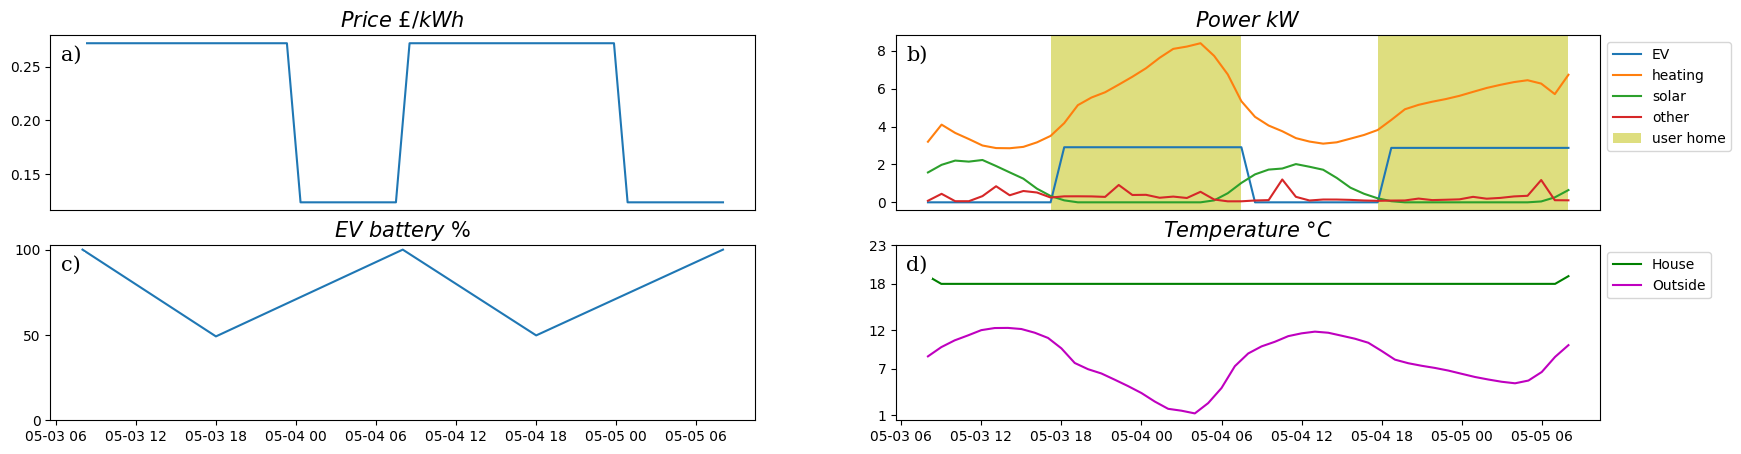

In [ ]:
management_system(model, tokenizer, mode="real", verbose=False, task_index=(3, 4), test=True)